In [15]:
%matplotlib inline

# DataProvider

In [16]:
import numpy as np

from dataprovider3 import Dataset
from dataprovider3 import emio

In [17]:
import os

base_dir = '~/Data_local/datasets/pinky/ground_truth'
base_dir = os.path.expanduser(base_dir)

def load_data(data_id):
    data_dir = os.path.join(base_dir, data_id)    

    # Image
    fpath = os.path.join(data_dir, 'img.h5')
    assert os.path.exists(fpath)
    img = emio.imread(fpath)
    img = (img/255.0).astype(np.float32)

    # Segmentation
    fpath = os.path.join(data_dir, 'seg.d10.b1.h5')
    assert os.path.exists(fpath)
    seg = emio.imread(fpath)

    # Mask    
    fpath = os.path.join(data_dir, 'msk_train.h5')
    if not os.path.exists(fpath):
        fpath = os.path.join(data_dir, 'msk.h5')
    assert os.path.exists(fpath)
    msk = emio.imread(fpath)
    
    return img, seg, msk

In [18]:
img, seg, msk = load_data('stitched_vol19-vol34')

In [19]:
import matplotlib.pyplot as plt

def plot_data(img, seg, msk):
    sz = 10
    fig = plt.figure(figsize=(sz,sz))

    plt.subplot(131)
    z = img.shape[-3]//2
    plt.imshow(img[z,:,:], cmap='gray')

    plt.subplot(132)
    z = img.shape[-3]//2
    plt.imshow(seg[z,:,:])

    plt.subplot(133)
    z = img.shape[-3]//2
    plt.imshow(msk[z,:,:], cmap='gray')
    plt.show()

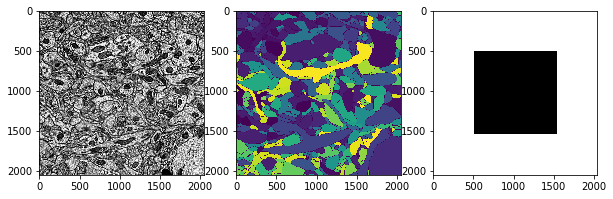

In [20]:
plot_data(img, seg, msk)

In [21]:
# Create Dataset.
dset = Dataset()
dset.add_data('img', img)
dset.add_data('seg', seg)
dset.add_mask('msk', msk, loc=True)

# Augmentor

In [22]:
import h5py

def save_sample(sample, fname='sample.h5'):
    with h5py.File(fname, 'w') as f:
        for k, v in sample.items():
            f.create_dataset(k, data=v)

In [23]:
def print_sample(sample):
    for k, v in sample.items():
        print('{} = {}'.format(k, v.shape))

## Flip

In [24]:
import augmentor
from augmentor.flip import *

In [25]:
aug = FlipRotate()
print(aug)

FlipRotate(
    Flip(axis=-1, prob=0.500)
    Flip(axis=-2, prob=0.500)
    Flip(axis=-3, prob=0.500)
    Transpose(axes=[0, 1, 3, 2], prob=0.500)
)


In [26]:
d = 256
spec = dict(img=(22,d,d), seg=(24,d,d), msk=(24,d,d))

In [27]:
import time

max_iter = 100
t0 = time.time()
for _ in range(max_iter):    
    spec2  = aug.prepare(dict(spec), imgs=['img'])
    sample = dset(spec=spec2)
    sample = aug(sample)
elapsed = time.time() - t0
print('{:.3f} s/iter'.format(elapsed/max_iter))

0.008 s/iter


In [28]:
save_sample(sample)

## Misalign

In [29]:
import augmentor
from augmentor import Misalign, MisalignPlusMissing, SlipMisalign

In [30]:
# aug = Misalign((5,25))
# aug = MisalignPlusMissing((5,25))
aug = SlipMisalign((5,25), interp=True)
print(aug)

SlipMisalign(disp=(5, 25), margin=1, interp=True)


In [31]:
d = 256
spec = dict(img=(22,d,d), seg=(24,d,d), msk=(24,d,d))

In [32]:
import time

max_iter = 100
t0 = time.time()
for _ in range(max_iter):    
    spec2  = aug.prepare(dict(spec), imgs=['img'])
    sample = dset(spec=spec2)
    sample = aug(sample)
elapsed = time.time() - t0
print('{:.3f} s/iter'.format(elapsed/max_iter))

0.010 s/iter


In [33]:
save_sample(sample)

## Missing

In [34]:
import augmentor
from augmentor import Compose
from augmentor.missing import *

augs = list()
augs.append(MixedMissingSection(maxsec=2, double=True, random=False))
augs.append(MixedMissingSection(prob=0.2, random=False))

aug = Compose(augs)
print(aug)

Compose(
    MixedMissingSection(perturb=<class 'augmentor.perturb.Fill'>, maxsec=2, skip=0.00, double=True, params={'value': 0, 'random': False})
    MixedMissingSection(perturb=<class 'augmentor.perturb.Fill'>, prob=0.20, skip=0.00, double=False, params={'value': 0, 'random': False})
)


In [35]:
# Sample spec
d = 256
spec = dict(img=(22,d,d), seg=(24,d,d), msk=(24,d,d))

In [36]:
import time

max_iter = 10
t0 = time.time()
for _ in range(max_iter):    
    spec2  = aug.prepare(dict(spec), imgs=['img'])
    sample = dset(spec=spec2)
    sample = aug(sample)
elapsed = time.time() - t0
print('{:.3f} s/iter'.format(elapsed/max_iter))

0.006 s/iter


In [37]:
save_sample(sample)

## Grayscale

In [38]:
import augmentor
from augmentor import Compose
from augmentor.grayscale import *

augs = list()
# augs.append(Grayscale2D(prob=1, skip=0))
augs.append(MixedGrayscale2D(
    prob=1, contrast_factor=0.5, brightness_factor=0.5, skip=0
))
# augs.append(Grayscale3D(skip=0))

aug = Compose(augs)
print(aug)

Compose(
    MixedGrayscale2D(perturb=<class 'augmentor.perturb.Grayscale'>, prob=1.00, skip=0.00, double=False, params={'contrast_factor': 0.5, 'brightness_factor': 0.5})
)


In [39]:
# Sample spec
d = 256
spec = dict(img=(22,d,d), seg=(24,d,d), msk=(24,d,d))

In [40]:
import time

max_iter = 10
t0 = time.time()
for _ in range(max_iter):    
    spec2  = aug.prepare(dict(spec), imgs=['img'])
    sample = dset(spec=spec2)
    sample = aug(sample)
elapsed = time.time() - t0
print('{:.3f} s/iter'.format(elapsed/max_iter))

0.086 s/iter


In [41]:
save_sample(sample)

## Out-of-focus

In [42]:
import augmentor
from augmentor.blur import *

aug = BlurrySection(prob=0.5)
print(aug)

BlurrySection(perturb=<class 'augmentor.perturb.Blur'>, prob=0.50, skip=0.00, double=False, params={'sigma': 5.0, 'random': True})


In [43]:
# Sample spec
d = 256
spec = dict(img=(22,d,d), seg=(24,d,d), msk=(24,d,d))

In [44]:
import time

max_iter = 10
t0 = time.time()
for _ in range(max_iter):    
    spec2  = aug.prepare(dict(spec), imgs=['img'])
    sample = dset(spec=spec2)
    sample = aug(sample)
elapsed = time.time() - t0
print('{:.3f} s/iter'.format(elapsed/max_iter))

0.056 s/iter


In [45]:
save_sample(sample)

## Warp

In [46]:
import augmentor
from augmentor import Warp

aug = Warp()
print(aug)

Warp(skip=0.00)


In [47]:
# Sample spec
d = 256
spec = dict(img=(22,d,d), seg=(24,d,d), msk=(24,d,d))

In [48]:
import time

max_iter = 10
t0 = time.time()
for _ in range(max_iter):    
    spec2  = aug.prepare(dict(spec), imgs=['img'])
    sample = dset(spec=spec2)
    sample = aug(sample)
elapsed = time.time() - t0
print('{:.3f} s/iter'.format(elapsed/max_iter))

0.115 s/iter


In [49]:
save_sample(sample)

## Compose

In [165]:
from augmentor import *

m1 = Blend([Misalign((0,10), margin=1), 
            SlipMisalign((0,10), margin=1)], props=[0.7,0.3])
m2 = Blend([Misalign((0,30), margin=1), 
            SlipMisalign((0,30), margin=1)], props=[0.7,0.3])
m3 = Blend([Misalign((0,50), margin=1), 
            SlipMisalign((0,50), margin=1)], props=[0.7,0.3])
m4 = Compose([
    MixedMissingSection(maxsec=1, double=True, random=False),
    MixedMissingSection(prob=0.2, double=False, random=False)
])

augs = list()
augs.append(
    MixedGrayscale2D(
        contrast_factor=0.5, 
        brightness_factor=0.5, 
        prob=1, skip=0.3))
augs.append(Blend([
    Compose([m1,m2,m3]),
    MisalignPlusMissing((5,30)),
    m4
]))
augs.append(MixedBlurrySection(prob=0.2))
augs.append(Warp(skip=0.3))
augs.append(FlipRotate())
aug = Compose(augs)

In [166]:
# Sample spec
d = 256
spec = dict(img=(22,d,d), seg=(24,d,d), msk=(24,d,d))

In [167]:
import time

max_iter = 10
t0 = time.time()
for _ in range(max_iter):    
    spec2  = aug.prepare(dict(spec), imgs=['img'])
    sample = dset(spec=spec2)
    sample = aug(sample)
elapsed = time.time() - t0
print('{:.3f} s/iter'.format(elapsed/max_iter))

0.212 s/iter


In [168]:
save_sample(sample)